<h1 align=center><font size = 5>Data Science and Machine Learning Capstone Project</font></h1>

### Question 3. Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?###

### Table of Contents

1. [Data preparation](#1)<br>
2. [Preliminary Analysis Based On Visual](#2)
    - [Lot](#21)
    - [LotArea](#22)
    - [BldgArea](#23)
    - [ResArea](#24)
    - [OfficeArea](#25)
    - [RetailArea](#26)
    - [NumBldgs](#27)
    - [NumFloors](#28)
    - [LotDepth](#29)
    - [BldgDepth](#210)
    - [YearBuilt](#211)
    - [YearAlter1](#212)  
    - [BuiltFAR](#213)
    - [ResidFAR](#214)
    - [CommFAR](#215)
    - [FacilFAR](#216)<br>    
3. [Checking Correlation Using Statistical Tests](#3)<br>
    - [One-Way Anova Test](#31)
    - [Kruskal-Wallis Test](#32)
4. [Conclusion](#3)<br>

***<font size = 4>Data preparation</font>***<a id="1"></a>

Import libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')

Import necessary data

In [2]:
# We reduce the columns to speed the process and since other columns it isn't really needed
columns_used1 = ['borough', 'city', 'complaint_type', 'incident_address', 'location_type','street_name', 'unique_key'] 
df_311= pd.read_csv('fhrw-4uyv.csv', usecols = columns_used1)
df_311.head()

,borough,city,complaint_type,incident_address,location_type,street_name,unique_key
0,MANHATTAN,NEW YORK,APPLIANCE,4530 BROADWAY,RESIDENTIAL BUILDING,BROADWAY,34931759
1,QUEENS,Richmond Hill,DOOR/WINDOW,86-41 127 STREET,RESIDENTIAL BUILDING,127 STREET,34931760
2,BROOKLYN,BROOKLYN,DOOR/WINDOW,788 NEW LOTS AVENUE,RESIDENTIAL BUILDING,NEW LOTS AVENUE,34931765
3,MANHATTAN,NEW YORK,DOOR/WINDOW,153 MANHATTAN AVENUE,RESIDENTIAL BUILDING,MANHATTAN AVENUE,34931771
4,BROOKLYN,BROOKLYN,SAFETY,613 EAST 16 STREET,RESIDENTIAL BUILDING,EAST 16 STREET,34931773


In [3]:
df_311.shape

(5619790, 7)

To simplify our work, we will narrow our focus on a particular borough, which is Bronx, since this borough are the one with the most severe problem of heat/hot water.

In [4]:
# remove all data except data with Bronx as borough value 
df_311 = df_311[df_311['borough'] == 'BRONX'].reset_index(drop = True)

# change the column name, useful when we merge it later
df_311.rename(columns = {'incident_address': 'Address'}, inplace =True)
df_311.head()

,borough,city,complaint_type,Address,location_type,street_name,unique_key
0,BRONX,BRONX,ELECTRIC,665 DAWSON STREET,RESIDENTIAL BUILDING,DAWSON STREET,34931780
1,BRONX,BRONX,FLOORING/STAIRS,63 EAST 177 STREET,RESIDENTIAL BUILDING,EAST 177 STREET,34931792
2,BRONX,BRONX,PLUMBING,871 BROOK AVENUE,RESIDENTIAL BUILDING,BROOK AVENUE,34931823
3,BRONX,BRONX,APPLIANCE,235 BROOK AVENUE,RESIDENTIAL BUILDING,BROOK AVENUE,34931856
4,BRONX,BRONX,HEAT/HOT WATER,741 WHITE PLAINS ROAD,RESIDENTIAL BUILDING,WHITE PLAINS ROAD,34931883


In [5]:
df_311.shape

(1485372, 7)

To answer the question above, we need to import PLUTO database so that we can have the buildings variabel/feature needed.

In [6]:
# using columns that are recommended by the problem set
columns_used2 = ['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 
                 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1']
df_pluto_bx = pd.read_csv('nyc_pluto_18v1/PLUTO_for_WEB/BX_18v1.csv', usecols = columns_used2)
df_pluto_bx.head()

,Lot,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR
0,1,122 BRUCKNER BOULEVARD,15000,0,0,0,0,1,0.0,200.0,0.0,0,0,0.00,6.02,5.0,6.5
1,4,126 BRUCKNER BOULEVARD,13770,752,0,272,0,2,1.0,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5
2,10,138 BRUCKNER BOULEVARD,35000,39375,0,0,0,1,2.0,200.0,200.0,1931,0,1.13,6.02,5.0,6.5
3,17,144 BRUCKNER BOULEVARD,2500,12500,12500,0,0,1,5.0,100.0,85.0,1931,2001,5.00,6.02,5.0,6.5
4,18,148 BRUCKNER BOULEVARD,1875,8595,6876,0,1719,1,5.0,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5


From documentation about Pluto database, we know that all feature/column we imported is a continuous variable. Therefore, we can do the next step, whic is scale all values in the columns that represent the building feature using MinMaxScaler, even though it will convert int64 into float64, which is OK.

In [7]:
normalized_columns = ['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 
                      'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 
                      'YearAlter1']
scaler = MinMaxScaler().fit(df_pluto_bx[normalized_columns])
df_pluto_bx[normalized_columns] = scaler.transform(df_pluto_bx[normalized_columns])
df_pluto_bx.head()

/home/hadji-mufushi/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Lot,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR
0,0.000000,122 BRUCKNER BOULEVARD,0.000202,0.000000,0.000000,0.000000,0.00000,0.003984,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.602,0.555556,0.65
1,0.000301,126 BRUCKNER BOULEVARD,0.000185,0.000056,0.000000,0.000207,0.00000,0.007968,0.022727,0.012500,0.012308,0.957362,0.988597,0.000192,0.602,0.555556,0.65
2,0.000902,138 BRUCKNER BOULEVARD,0.000471,0.002908,0.000000,0.000000,0.00000,0.003984,0.045455,0.025000,0.153846,0.957362,0.000000,0.004349,0.602,0.555556,0.65
3,0.001604,144 BRUCKNER BOULEVARD,0.000034,0.000923,0.000946,0.000000,0.00000,0.003984,0.113636,0.012500,0.065385,0.957362,0.992067,0.019246,0.602,0.555556,0.65
4,0.001704,148 BRUCKNER BOULEVARD,0.000025,0.000635,0.000520,0.000000,0.00287,0.003984,0.113636,0.009375,0.053846,0.951909,0.996034,0.017629,0.602,0.555556,0.65


Next. lets merge **df_311** with **df_pluto_bx** so that we can connect the complaint with the building characteristics which the complaint comes from.

In [8]:
# merge the dataframes with how = 'inner' to remove all data with building not listed in pluto database.
new_df_311= df_311.merge(df_pluto_bx, on = 'Address', how = 'inner')
new_df_311.head()

,borough,city,complaint_type,Address,location_type,street_name,unique_key,Lot,LotArea,BldgArea,...,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR
0,BRONX,BRONX,PLUMBING,871 BROOK AVENUE,RESIDENTIAL BUILDING,BROOK AVENUE,34931823,0.002806,0.000073,0.001235,...,0.003984,0.113636,0.005812,0.029231,0.954388,0.0,0.011817,0.344,0.377778,0.65
1,BRONX,BRONX,PAINT/PLASTER,871 BROOK AVENUE,RESIDENTIAL BUILDING,BROOK AVENUE,34933599,0.002806,0.000073,0.001235,...,0.003984,0.113636,0.005812,0.029231,0.954388,0.0,0.011817,0.344,0.377778,0.65
2,BRONX,BRONX,HEAT/HOT WATER,871 BROOK AVENUE,RESIDENTIAL BUILDING,BROOK AVENUE,34934222,0.002806,0.000073,0.001235,...,0.003984,0.113636,0.005812,0.029231,0.954388,0.0,0.011817,0.344,0.377778,0.65
3,BRONX,BRONX,PLUMBING,871 BROOK AVENUE,RESIDENTIAL BUILDING,BROOK AVENUE,34938245,0.002806,0.000073,0.001235,...,0.003984,0.113636,0.005812,0.029231,0.954388,0.0,0.011817,0.344,0.377778,0.65
4,BRONX,BRONX,APPLIANCE,871 BROOK AVENUE,RESIDENTIAL BUILDING,BROOK AVENUE,34938359,0.002806,0.000073,0.001235,...,0.003984,0.113636,0.005812,0.029231,0.954388,0.0,0.011817,0.344,0.377778,0.65


In [9]:
new_df_311.shape

(1202224, 23)

Lets check the number of missing value for each columns to make sure that we have enough data for further processes and the proportion compared to total data is not large enough to invalidate the results of our analysis.

In [10]:
missing_data_new_311= new_df_311.isnull()
missing_data_new_311.head()

,borough,city,complaint_type,Address,location_type,street_name,unique_key,Lot,LotArea,BldgArea,...,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
for column in missing_data_new_311.columns.values.tolist():
    print(column)
    #Menghitung jumlah masing-masing nilai unik pada kolom data
    print (missing_data_new_311[column].value_counts())
    print("")

borough
False    1202224
Name: borough, dtype: int64

city
False    1193800
True        8424
Name: city, dtype: int64

complaint_type
False    1202224
Name: complaint_type, dtype: int64

Address
False    1202155
True          69
Name: Address, dtype: int64

location_type
False    1202224
Name: location_type, dtype: int64

street_name
False    1202155
True          69
Name: street_name, dtype: int64

unique_key
False    1202224
Name: unique_key, dtype: int64

Lot
False    1202224
Name: Lot, dtype: int64

LotArea
False    1202224
Name: LotArea, dtype: int64

BldgArea
False    1202224
Name: BldgArea, dtype: int64

ResArea
False    1202224
Name: ResArea, dtype: int64

OfficeArea
False    1202224
Name: OfficeArea, dtype: int64

RetailArea
False    1202224
Name: RetailArea, dtype: int64

NumBldgs
False    1202224
Name: NumBldgs, dtype: int64

NumFloors
False    1202224
Name: NumFloors, dtype: int64

LotDepth
False    1202224
Name: LotDepth, dtype: int64

BldgDepth
False    1202224
Name: Bldg

We see that most of the features that represent the buildings characteristic from pluto database doesn't contain missing values, even the feature that does, it only have a very small quantity of it. Therefore, we can safely assume that the missing values in our data won't have much impact in interfering our analysis results and thus we can take the next step in this process.

Lets group our data based on **complaint type**

In [12]:
new_df_311_grouped = new_df_311.groupby(by = 'complaint_type')

In [13]:
new_df_311_grouped.count()

,borough,city,Address,location_type,street_name,unique_key,Lot,LotArea,BldgArea,ResArea,...,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR
complaint_type,,,,,,,,,,,,,,,,,,,,,
AGENCY,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
APPLIANCE,23216,23126,23216,23216,23216,23216,23216,23216,23216,23216,...,23216,23216,23216,23216,23216,23216,23216,23216,23216,23216
CONSTRUCTION,766,758,766,766,766,766,766,766,766,766,...,766,766,766,766,766,766,766,766,766,766
DOOR/WINDOW,45351,45178,45351,45351,45351,45351,45351,45351,45351,45351,...,45351,45351,45351,45351,45351,45351,45351,45351,45351,45351
ELECTRIC,57947,57684,57947,57947,57947,57947,57947,57947,57947,57947,...,57947,57947,57947,57947,57947,57947,57947,57947,57947,57947
ELEVATOR,1163,1160,1163,1163,1163,1163,1163,1163,1163,1163,...,1163,1163,1163,1163,1163,1163,1163,1163,1163,1163
FLOORING/STAIRS,31184,31081,31184,31184,31184,31184,31184,31184,31184,31184,...,31184,31184,31184,31184,31184,31184,31184,31184,31184,31184
GENERAL,27673,27540,27673,27673,27673,27673,27673,27673,27673,27673,...,27673,27673,27673,27673,27673,27673,27673,27673,27673,27673
GENERAL CONSTRUCTION,96110,95617,96110,96110,96110,96110,96110,96110,96110,96110,...,96110,96110,96110,96110,96110,96110,96110,96110,96110,96110


***<font size = 4>Preliminary Analysis Based On Visual</font>***<a id="2"></a>

In this step, Lets create bar plot that describe mean of each feature based on the complaint type to check whether there is an indication that the feature has a correlation with complaint type variable. First, lets create a plot function.

In [14]:
def bar_mean_plot(feature):
    new_df_311_grouped[feature].mean().sort_values(ascending = True).plot(kind = 'bar', figsize = (10, 7))
    plt.xticks(rotation=75)
    plt.xlabel('Complaint Type')
    plt.ylabel('Mean '+ feature)

***<font size = 3>1. Lot</font>***<a id="21"></a>

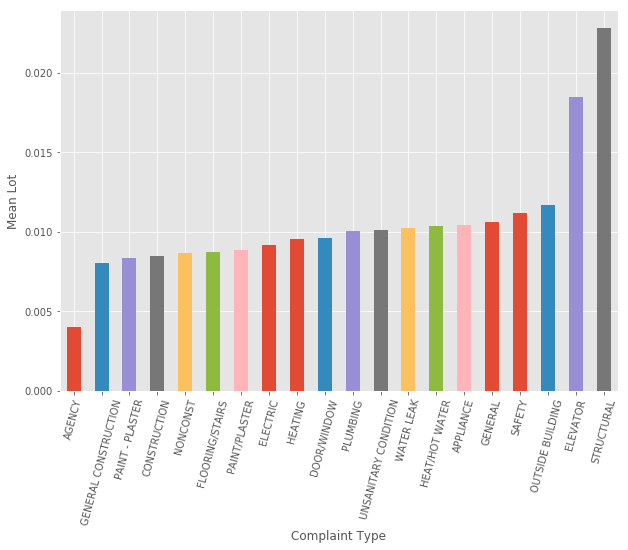

In [15]:
bar_mean_plot('Lot')

Seems, there is an indication that **Lot** has a correlation with **complaint_type**. Lets look for the rest of features.

***<font size = 3>2. LotArea</font>***<a id="22"></a>

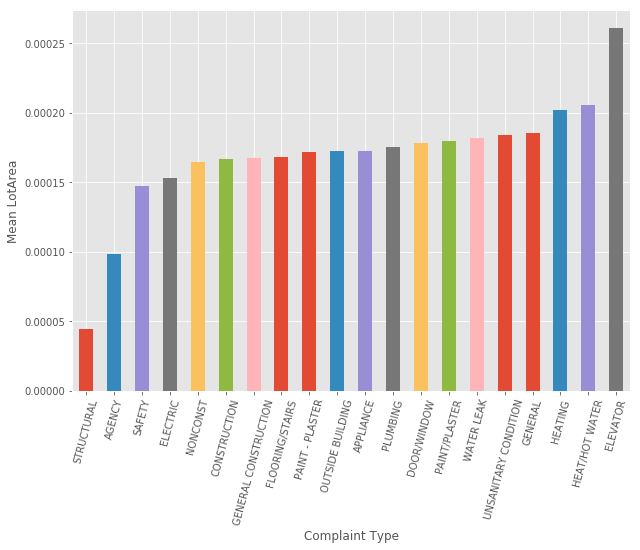

In [16]:
bar_mean_plot('LotArea')

***<font size = 3>3. BldgArea</font>***<a id="23"></a>

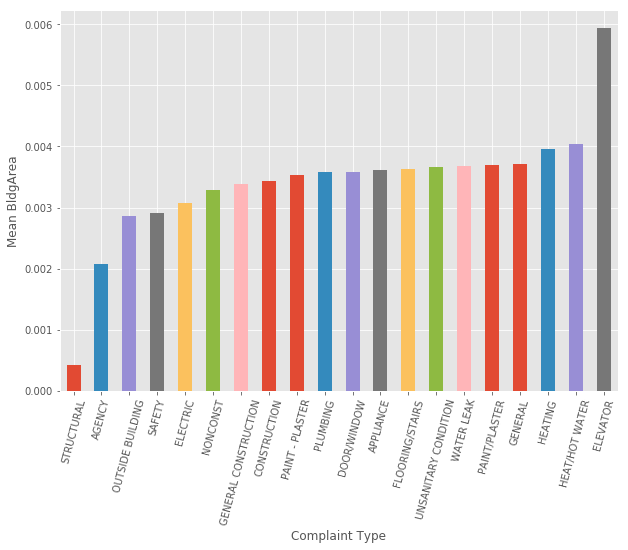

In [17]:
bar_mean_plot('BldgArea')

***<font size = 3>4. ResArea</font>***<a id="24"></a>

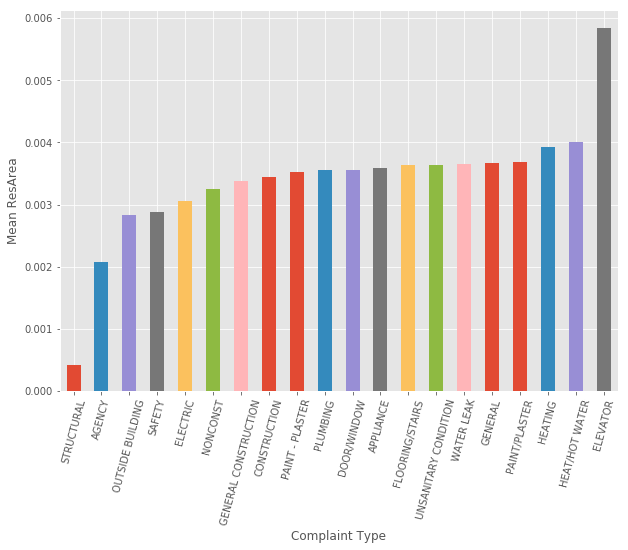

In [18]:
bar_mean_plot('ResArea')

***<font size = 3>5. OfficeArea</font>***<a id="25"></a>

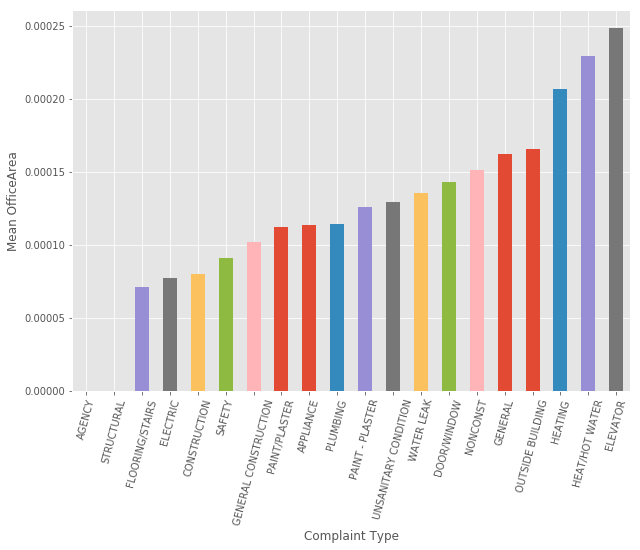

In [19]:
bar_mean_plot('OfficeArea')

***<font size = 3>6. RetailArea</font>***<a id="26"></a>

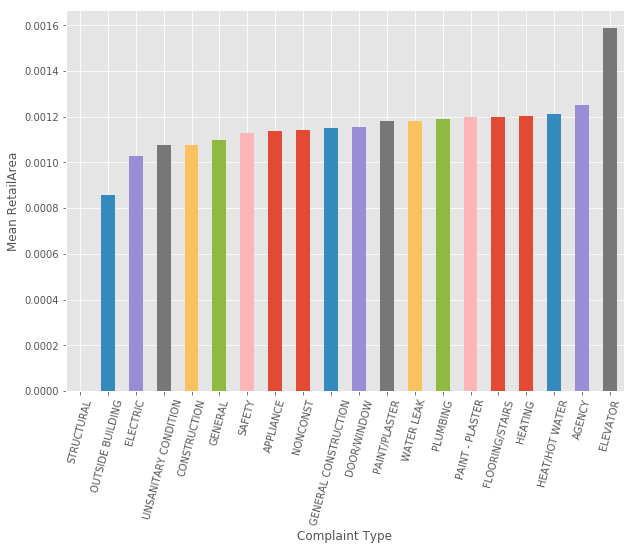

In [20]:
bar_mean_plot('RetailArea')

***<font size = 3>7. NumBldgs</font>***<a id="27"></a>

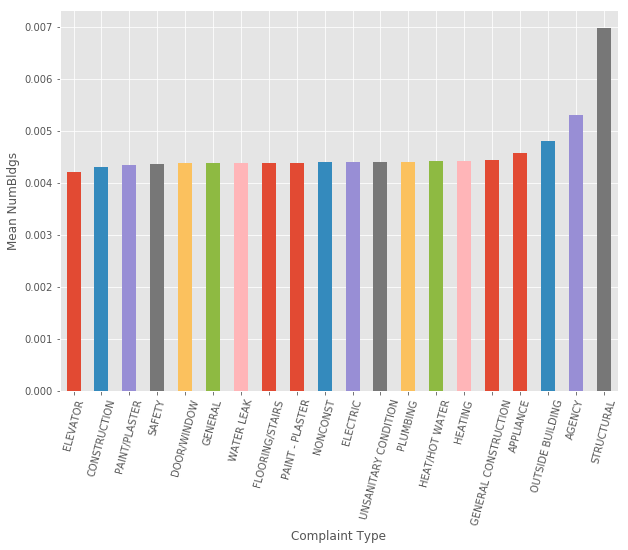

In [21]:
bar_mean_plot('NumBldgs')

***<font size = 3>8. NumFloors</font>***<a id="28"></a>

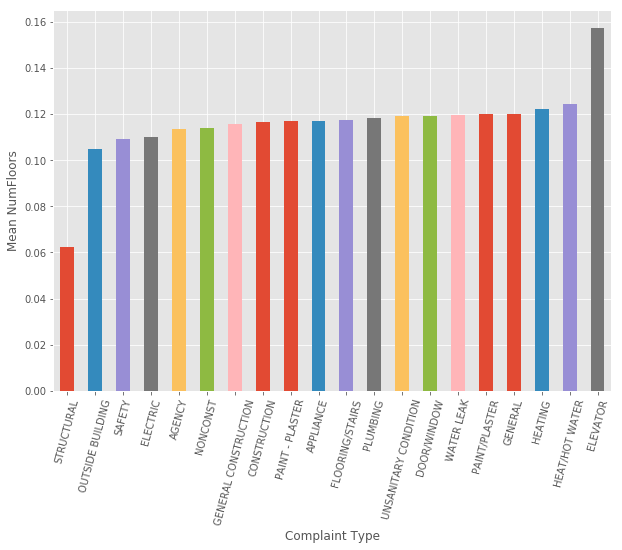

In [22]:
bar_mean_plot('NumFloors')

***<font size = 3>9. LotDepth</font>***<a id="29"></a>

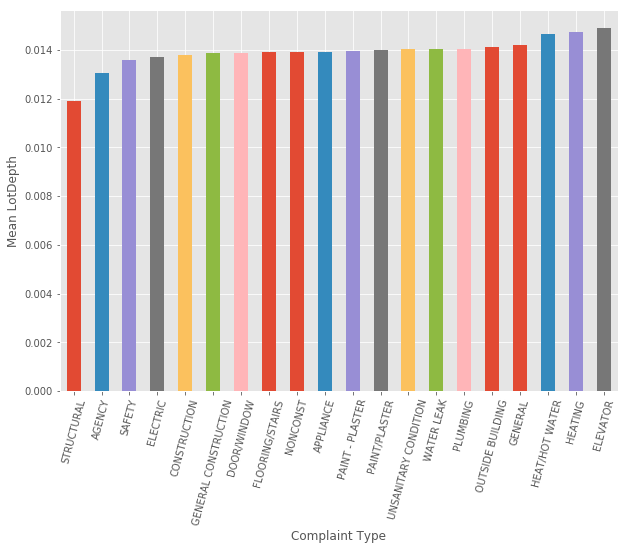

In [23]:
bar_mean_plot('LotDepth')

***<font size = 3>10. BldgDepth</font>***<a id="210"></a>

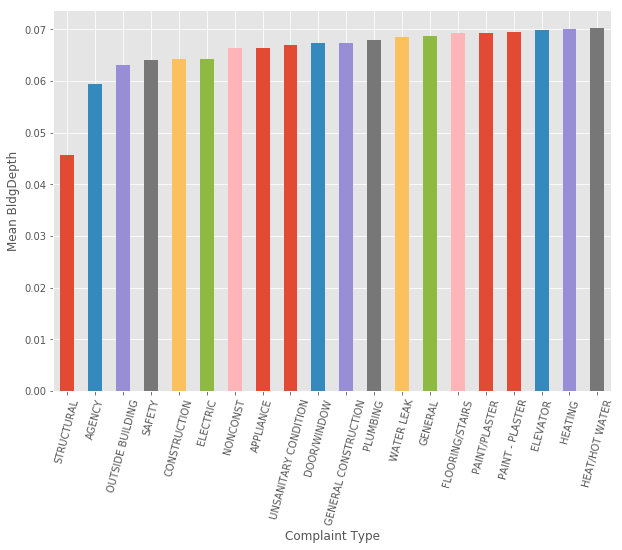

In [24]:
bar_mean_plot('BldgDepth')

***<font size = 3>11. YearBuilt</font>***<a id="211"></a>

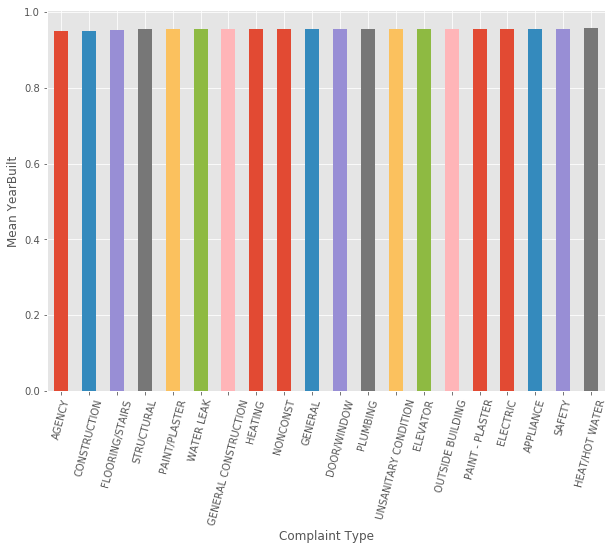

In [25]:
bar_mean_plot('YearBuilt')

***<font size = 3>12. YearAlter1</font>***<a id="212"></a>

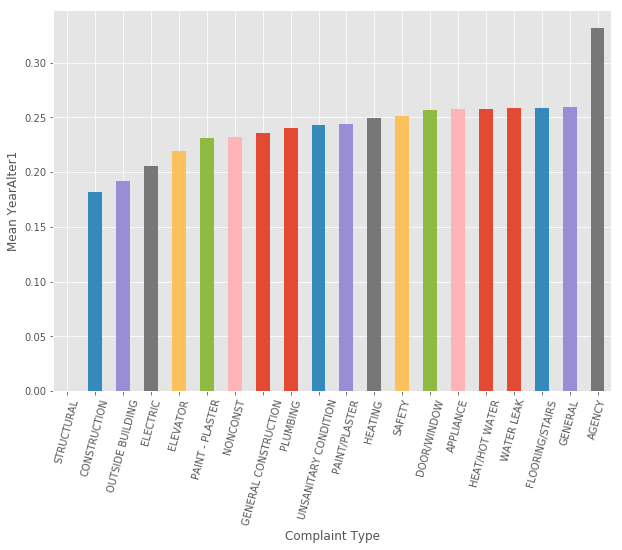

In [26]:
bar_mean_plot('YearAlter1')

***<font size = 3>13. BuiltFAR</font>***<a id="213"></a>

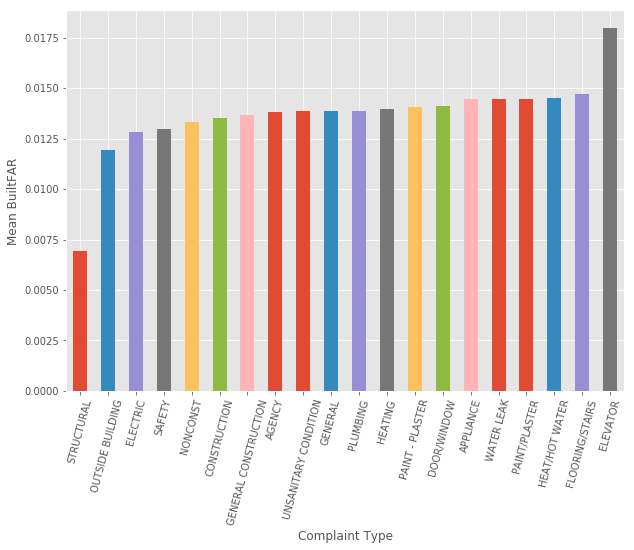

In [27]:
bar_mean_plot('BuiltFAR')

***<font size = 3>14. ResidFAR</font>***<a id="214"></a>

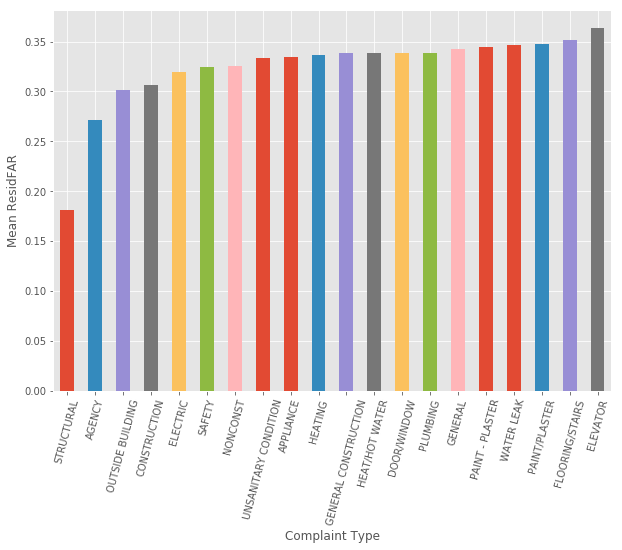

In [28]:
bar_mean_plot('ResidFAR')

***<font size = 3>15. CommFAR</font>***<a id="215"></a>

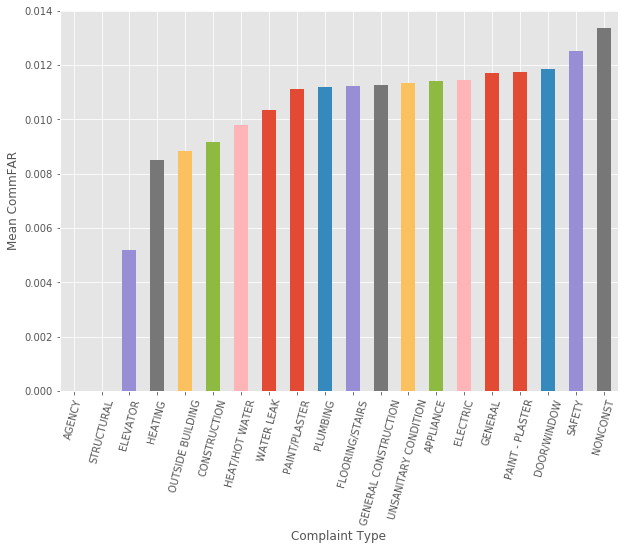

In [29]:
bar_mean_plot('CommFAR')

***<font size = 3>16. FacilFAR</font>***<a id="216"></a>

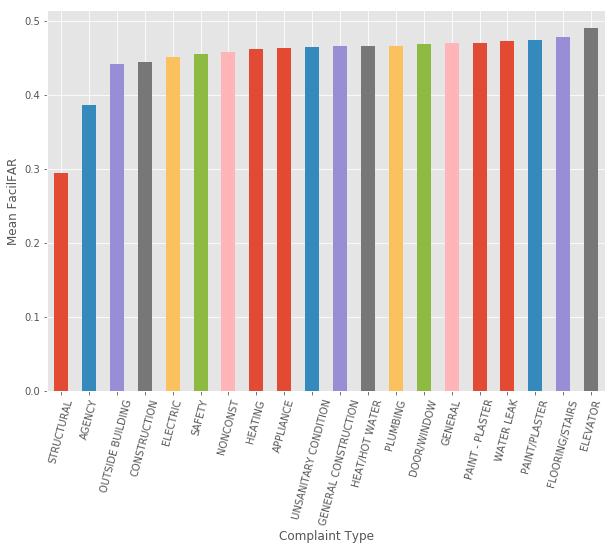

In [30]:
bar_mean_plot('FacilFAR')

Based on all plots for every building feature above, There seems to be indication that the features listed below have a correlation with complaint type, which are:
<ol>
    <li>Lot</li>
    <li>LotArea</li> 
    <li>BldgArea</li>
    <li>ResArea</li>
    <li>OfficeArea</li>
    <li>RetailArea</li>
    <li>NumFloors</li>
    <li>YearAlter1</li>
    <li>BuiltFAR</li>
    <li>ResidFAR</li>
    <li>CommFAR</li>
</ol>
As for NumBldgs, LotDepth, BldgDepth, YearBuilt and FacilFAR, we cannot take any conclusion since the mean for these features seems equal.

(Note: For NumBldgs, BldgDepth, FacilFAR, we take STRUCTURAL and AGENCY complaint type out of the equation, because even though the means for this complaint in those feature show a relatively different with the others, the number of data/sample is not enough to justify that there is an indication for those features to correlate with complaint type.)

***<font size = 4>Checking Correlation Using Statistical Tests</font>***<a id="3"></a>

For this step, we will make decisison whether a characteristic of buildings has a correlation with complaint type using Anova and Kruskal-Wallis test.

***<font size = 3>One-Way Anova Test</font>***<a id="31"></a>

In [32]:
# ANOVA

def anova(var):
    f_val, p_val = stats.f_oneway(new_df_311_grouped.get_group('AGENCY')[var], new_df_311_grouped.get_group('APPLIANCE')[var]
                             , new_df_311_grouped.get_group('CONSTRUCTION')[var], new_df_311_grouped.get_group('DOOR/WINDOW')[var]
                             , new_df_311_grouped.get_group('ELECTRIC')[var], new_df_311_grouped.get_group('ELEVATOR')[var]
                             , new_df_311_grouped.get_group('FLOORING/STAIRS')[var], new_df_311_grouped.get_group('GENERAL')[var]
                             , new_df_311_grouped.get_group('GENERAL CONSTRUCTION')[var], new_df_311_grouped.get_group('HEAT/HOT WATER')[var]
                             , new_df_311_grouped.get_group('HEATING')[var], new_df_311_grouped.get_group('NONCONST')[var]
                             , new_df_311_grouped.get_group('OUTSIDE BUILDING')[var], new_df_311_grouped.get_group('PAINT - PLASTER')[var]
                             , new_df_311_grouped.get_group('PAINT/PLASTER')[var], new_df_311_grouped.get_group('PLUMBING')[var]
                             , new_df_311_grouped.get_group('SAFETY')[var], new_df_311_grouped.get_group('STRUCTURAL')[var]
                             , new_df_311_grouped.get_group('UNSANITARY CONDITION')[var], new_df_311_grouped.get_group('WATER LEAK')[var])  
 
    print( var, "ANOVA results: F=", f_val, ", P =", p_val)

In [33]:
columns_used3 = ['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 
                 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1']

for i in columns_used3:
    anova(i)

BldgArea ANOVA results: F= 224.84161101256126 , P = 0.0
BldgDepth ANOVA results: F= 228.0699108653007 , P = 0.0
BuiltFAR ANOVA results: F= 119.0148165996341 , P = 0.0
CommFAR ANOVA results: F= 25.89397028086444 , P = 2.8088344763247866e-92
FacilFAR ANOVA results: F= 95.16233880167616 , P = 0.0
Lot ANOVA results: F= 13.288305656321405 , P = 9.85579895723784e-43
LotArea ANOVA results: F= 112.98938182987479 , P = 0.0
LotDepth ANOVA results: F= 259.6567389264597 , P = 0.0
NumBldgs ANOVA results: F= 7.172186583449852 , P = 9.424159641467696e-20
NumFloors ANOVA results: F= 397.8968186020166 , P = 0.0
OfficeArea ANOVA results: F= 15.347778690973877 , P = 1.0624346293891702e-50
ResArea ANOVA results: F= 216.03950877791738 , P = 0.0
ResidFAR ANOVA results: F= 113.60253965056842 , P = 0.0
RetailArea ANOVA results: F= 12.638281534034833 , P = 3.100923528418365e-40
YearBuilt ANOVA results: F= 18.2574747745285 , P = 4.583071718705318e-62
YearAlter1 ANOVA results: F= 60.036946481964264 , P = 5.89908

Suppose the data violated the assumptions for one-way Anova test p-value to be valid, lets check using another method, which is called Kruskal-Wallis test.

***<font size = 3>Kruskal-Wallis Test</font>***<a id="32"></a>

In [94]:
def kruskal_wallis_test(var):
    f_val, p_val = stats.kruskal(new_df_311_grouped.get_group('APPLIANCE')[var]
                             , new_df_311_grouped.get_group('CONSTRUCTION')[var], new_df_311_grouped.get_group('DOOR/WINDOW')[var]
                             , new_df_311_grouped.get_group('ELECTRIC')[var], new_df_311_grouped.get_group('ELEVATOR')[var]
                             , new_df_311_grouped.get_group('FLOORING/STAIRS')[var], new_df_311_grouped.get_group('GENERAL')[var]
                             , new_df_311_grouped.get_group('GENERAL CONSTRUCTION')[var], new_df_311_grouped.get_group('HEAT/HOT WATER')[var]
                             , new_df_311_grouped.get_group('HEATING')[var], new_df_311_grouped.get_group('NONCONST')[var]
                             , new_df_311_grouped.get_group('OUTSIDE BUILDING')[var], new_df_311_grouped.get_group('PAINT - PLASTER')[var]
                             , new_df_311_grouped.get_group('PAINT/PLASTER')[var], new_df_311_grouped.get_group('PLUMBING')[var]
                             , new_df_311_grouped.get_group('SAFETY')[var]
                             , new_df_311_grouped.get_group('UNSANITARY CONDITION')[var], new_df_311_grouped.get_group('WATER LEAK')[var])  
 
    print( var, ",Kruskal-Wallis test results: Statistic=", f_val, ", P =", p_val)

We remove data for AGENCY and STRUCTURAL complaint type from the function above, because we don't meet the minimum number of data for those type to perform Kruskal-Wallis test, which needed at least 5 data.

In [95]:
for i in columns_used3:
    kruskal_wallis_test(i)

BldgArea ,Kruskal-Wallis test results: Statistic= 12077.829896016972 , P = 0.0
BldgDepth ,Kruskal-Wallis test results: Statistic= 5200.035837505102 , P = 0.0
BuiltFAR ,Kruskal-Wallis test results: Statistic= 6243.550066512143 , P = 0.0
CommFAR ,Kruskal-Wallis test results: Statistic= 487.8489558225431 , P = 6.84970275986451e-93
FacilFAR ,Kruskal-Wallis test results: Statistic= 1678.3726401607403 , P = 0.0
Lot ,Kruskal-Wallis test results: Statistic= 2000.0079506938027 , P = 0.0
LotArea ,Kruskal-Wallis test results: Statistic= 11661.215568188687 , P = 0.0
LotDepth ,Kruskal-Wallis test results: Statistic= 3978.4838819610573 , P = 0.0
NumBldgs ,Kruskal-Wallis test results: Statistic= 390.70029228288615 , P = 1.626782090213319e-72
NumFloors ,Kruskal-Wallis test results: Statistic= 10775.733412308591 , P = 0.0
OfficeArea ,Kruskal-Wallis test results: Statistic= 3360.297656825903 , P = 0.0
ResArea ,Kruskal-Wallis test results: Statistic= 11814.956054277614 , P = 0.0
ResidFAR ,Kruskal-Wallis 

***<font size = 4>Conclusion</font>***<a id="4"></a>

Based on two method above, taking critical alpha value 0.01, all p-value fall in critical area. Therefore, we conclude that there is a correlation between complaint type and all building features below:

<ol>
    <li>BldgArea</li>
    <li>BldgDepth</li>
    <li>BuiltFAR</li>
    <li>CommFAR</li>
    <li>FacilFAR</li>
    <li>Lot</li>
    <li>LotArea</li>
    <li>LotDepth</li>
    <li>NumBldgs</li>
    <li>NumFloors</li>
    <li>OfficeArea</li>
    <li>ResArea</li>
    <li>ResidFAR</li>
    <li>RetailArea</li>
    <li>YearBuilt</li>
    <li>YearAlter1</li>
</ol>

Note: You can check more about Anova and Kruskal-Wallis Test from documentation in scipy website.

***<font size = 3>Author : Hadi Muhshi</font>*** 